# Installating Packages

In [1]:
pip install numpy pandas scikit-learn nltk joblib streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.1 MB/s eta 0:00:00


## Importing Libraries

In [2]:
import json
import re
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.sparse import hstack


## Data Preprocessing

In [3]:
DATA_PATH = "problems_data.jsonl"

records = []
with open(DATA_PATH, "r", encoding="utf-8") as f:
    for line in f:
        records.append(json.loads(line))

df = pd.DataFrame(records)
df.head()

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


In [4]:
print(df.shape)

(4112, 8)


In [5]:
print("Class distribution:")
print(df["problem_class"].value_counts())

Class distribution:
problem_class
hard      1941
medium    1405
easy       766
Name: count, dtype: int64


In [6]:
print("\nScore statistics:")
df["problem_score"].describe()


Score statistics:


,problem_score
count,4112.000000
mean,5.114689
std,2.177770
min,1.100000
25%,3.300000
50%,5.200000
75%,6.900000
max,9.700000


## Class Distribution

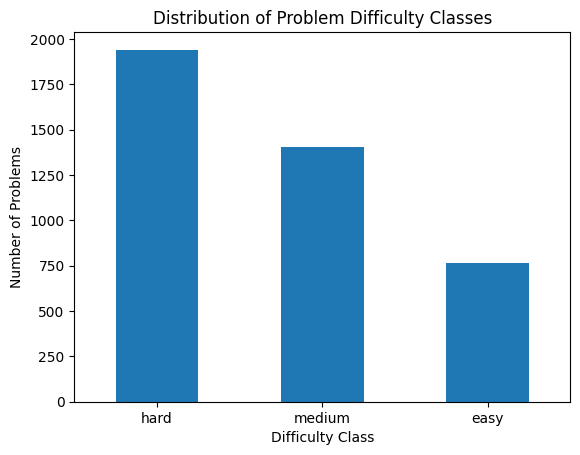

In [7]:
import matplotlib.pyplot as plt

df["problem_class"].value_counts().plot(
    kind="bar",
    title="Distribution of Problem Difficulty Classes",
    ylabel="Number of Problems",
    xlabel="Difficulty Class",
    rot=0
)
plt.show()


## Problem Score Distribution

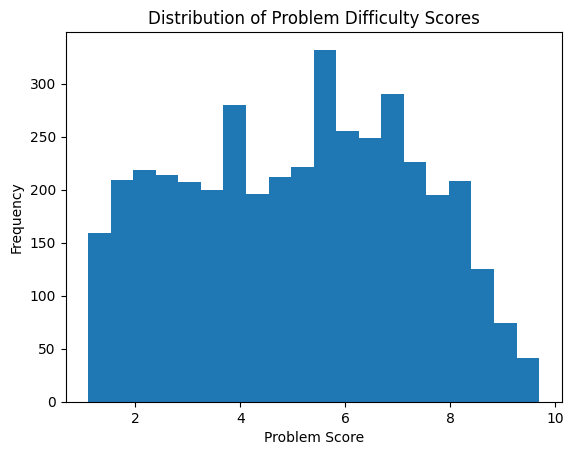

In [8]:
plt.hist(df["problem_score"], bins=20)
plt.xlabel("Problem Score")
plt.ylabel("Frequency")
plt.title("Distribution of Problem Difficulty Scores")
plt.show()


# Handle Missing Values

In [9]:
# Fill missing text fields with empty string
text_cols = ["title", "description", "input_description", "output_description"]

for col in text_cols:
    df[col] = df[col].fillna("")

# Drop rows where labels are missing
df = df.dropna(subset=["problem_class", "problem_score"])


## Combine All Text Fields

In [10]:
df["combined_text"] = (
    df["title"] + " " +
    df["description"] + " " +
    df["input_description"] + " " +
    df["output_description"]
)


## Basic Text Cleaning

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"[^a-z0-9+\-*/=<>() ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["combined_text"] = df["combined_text"].apply(clean_text)


# Feature Engineering

## Text Length Features

In [12]:
df["text_length"] = df["combined_text"].apply(len)
df["word_count"] = df["combined_text"].apply(lambda x: len(x.split()))


## Mathematical Symbol Count

In [13]:
math_symbols = r"[+\-*/=<>]"
df["math_symbol_count"] = df["combined_text"].apply(
    lambda x: len(re.findall(math_symbols, x))
)


## Keyword-Based Difficulty Signals

In [14]:
keywords = [
    "graph", "tree", "dp", "dynamic programming",
    "recursion", "greedy", "binary search",
    "dfs", "bfs", "heap", "segment tree"
]

for kw in keywords:
    df[f"kw_{kw.replace(' ', '_')}"] = df["combined_text"].apply(
        lambda x: x.count(kw)
    )


# Feature Extraction (TF-IDF + Engineered Features)

## TF-IDF Vectorization

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,1),
    stop_words="english"
)


X_tfidf = tfidf.fit_transform(df["combined_text"])


## Combine TF-IDF with Engineered Features

In [16]:
engineered_features = df[
    ["text_length", "word_count", "math_symbol_count"]
].values

X = hstack([X_tfidf, engineered_features])


## Top TF-IDF terms

In [17]:
feature_names = tfidf.get_feature_names_out()
idf_scores = tfidf.idf_

top_words = sorted(
    zip(feature_names, idf_scores),
    key=lambda x: x[1],
    reverse=True
)[:20]

top_words


[('0x67', np.float64(8.62876078767048)),
 ('agamemnon', np.float64(8.62876078767048)),
 ('agenda', np.float64(8.62876078767048)),
 ('amt', np.float64(8.62876078767048)),
 ('bakeries', np.float64(8.62876078767048)),
 ('bans', np.float64(8.62876078767048)),
 ('bdd', np.float64(8.62876078767048)),
 ('blacksquare', np.float64(8.62876078767048)),
 ('blu', np.float64(8.62876078767048)),
 ('boar', np.float64(8.62876078767048)),
 ('brice', np.float64(8.62876078767048)),
 ('bryan', np.float64(8.62876078767048)),
 ('canvasses', np.float64(8.62876078767048)),
 ('catname', np.float64(8.62876078767048)),
 ('chad', np.float64(8.62876078767048)),
 ('champagne', np.float64(8.62876078767048)),
 ('champions', np.float64(8.62876078767048)),
 ('chapters', np.float64(8.62876078767048)),
 ('christie', np.float64(8.62876078767048)),
 ('cp', np.float64(8.62876078767048))]

# Train-Test Split

In [18]:
from sklearn.model_selection import train_test_split

y_class = df["problem_class"]
y_score = df["problem_score"]

X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X, y_class, y_score,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)


# Model 1: Difficulty Classification
## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=1000,
    random_state=42
)
clf.fit(X_train, y_class_train)

y_class_pred = clf.predict(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [21]:
print("Accuracy:", accuracy_score(y_class_test, y_class_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_class_test, y_class_pred))
print("\nClassification Report:\n", classification_report(y_class_test, y_class_pred))

Accuracy: 0.4957472660996355

Confusion Matrix:
 [[ 45  56  52]
 [ 20 279  90]
 [ 21 176  84]]

Classification Report:
               precision    recall  f1-score   support

        easy       0.52      0.29      0.38       153
        hard       0.55      0.72      0.62       389
      medium       0.37      0.30      0.33       281

    accuracy                           0.50       823
   macro avg       0.48      0.44      0.44       823
weighted avg       0.48      0.50      0.48       823



## Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_clf = RandomForestClassifier(
    n_estimators=600,
    max_depth=40,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_clf.fit(X_train, y_class_train)

y_class_pred = rf_clf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_class_test, y_class_pred))
print("\nClassification Report:\n", classification_report(y_class_test, y_class_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_class_test, y_class_pred))


Random Forest Accuracy: 0.5212636695018226

Classification Report:
               precision    recall  f1-score   support

        easy       0.46      0.47      0.46       153
        hard       0.57      0.79      0.66       389
      medium       0.39      0.17      0.24       281

    accuracy                           0.52       823
   macro avg       0.47      0.48      0.45       823
weighted avg       0.49      0.52      0.48       823


Confusion Matrix:
 [[ 72  52  29]
 [ 35 309  45]
 [ 51 182  48]]


## Feature Selection Using RF : Accuracy Increased

In [23]:
import numpy as np

importances = rf_clf.feature_importances_
top_idx = np.argsort(importances)[-5000:]  # keep top 5000 features

X_train_rf = X_train[:, top_idx]
X_test_rf = X_test[:, top_idx]

rf_clf.fit(X_train_rf, y_class_train)
y_pred = rf_clf.predict(X_test_rf)


In [24]:
print("Improved Accuracy:", accuracy_score(y_class_test, y_pred))
print("Classification Report:\n", classification_report(y_class_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_class_test, y_pred))

Improved Accuracy: 0.5407047387606319
Classification Report:
               precision    recall  f1-score   support

        easy       0.47      0.48      0.47       153
        hard       0.58      0.81      0.68       389
      medium       0.44      0.20      0.27       281

    accuracy                           0.54       823
   macro avg       0.50      0.50      0.48       823
weighted avg       0.51      0.54      0.50       823


Confusion Matrix:
 [[ 73  50  30]
 [ 33 317  39]
 [ 49 177  55]]


## Model 2: Difficulty Score Regression

In [25]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_score_train)


y_score_pred = reg.predict(X_test)


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_score_test, y_score_pred)
rmse = np.sqrt(mean_squared_error(y_score_test, y_score_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 2.495633321790916
RMSE: 3.1508262679062633


# Save Trained Models

## Save TF-IDF Vectorizer

In [27]:
import joblib

joblib.dump(tfidf, "vectorizer.pkl")

['vectorizer.pkl']

## Save Classification Model

In [28]:
joblib.dump(rf_clf, "classifier.pkl")

['classifier.pkl']

## Save Regression Model

In [29]:
joblib.dump(reg, "regressor.pkl")

['regressor.pkl']

##Save Keyword List

In [30]:
joblib.dump(keywords, "keywords.pkl")

['keywords.pkl']